In [1]:
# Алексеев Д.П. (DSU-4,FEML-8)
# Домашнее задание к лекции «Проблема качества данных» (#5).

# Задание:
# Необходимо запустить практическую часть занятия, и посмотреть самому то, о чём говорили на лекции. 
# По образу практики, попробуйте создать искусственный датасет с лишними столбцами. 
# Целевую метку, при правильной обработке данных, формируйте таким образом, 
# чтобы без затруднений её смогла описать линейная модель. Ориентируйтесь на то, что было показано во время занятия, 
# и каждый шаг описывайте в markdown. Здесь важно видеть ваш ход мысли. Не бойтесь ошибиться или написать не то. 
# Данное задание не имеет какого-то “правильного” решения. 
# Цель - достичь базового понимания проблемы. Чем больше вы фантазируете, тем лучше :) 
# Тем не менее, старайтесь представить те ситуации, которые по-вашему мнению могли бы быть в реальных данных. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
# Cформируем произвольный датасет на 5000 записей,
# описывающих стоимость поездок на разных автомобилях на дальние расстояния
n_samples = 5000
np.random.seed(21) #зафиксируем seed

# Опишем входящие признаки модели
# 1.дальность одной поездки в км
distance = np.random.choice(2000, n_samples) + 100

# 2.среднее потребление бензина автомобилем в литрах на 100 км пути
consumption = np.random.choice(12, n_samples) + 5

# 3.стоимость бензина в рублях за 1 литр
price = np.random.choice(7, n_samples) + 48

# 4.количество пассажиров в а/м (без учета водителя!)
# Данный параметр вводим в модель, т.к. количество (вес) пассажиров в а/м напрямую влияет на расход топлива.
# Допустим, что каждый пассажир приводит к увеличению расхода топлива на 5%.
passengers = np.random.choice(5, n_samples)

# Опишем целевой параметр:
# 5.общая стоимость поездки в рублях в расчете на один а/м, учитывая поправочный коэфф-т на кол-во пассажиров
gross_value = distance/100 * consumption * price * (1 + 0.05*passengers)

data = pd.DataFrame({'distance': distance, 'consumption': consumption, 'price': price, 
                     'passengers': passengers, 'gross_value': np.around(gross_value, decimals=2)})
data.head(10)

,distance,consumption,price,passengers,gross_value
0,1069,16,49,4,10057.15
1,1331,15,48,3,11020.68
2,1948,15,52,3,17473.56
3,872,5,51,2,2445.96
4,148,11,52,1,888.89
5,468,12,54,1,3184.27
6,1244,6,50,0,3732.00
7,1543,5,52,3,4613.57
8,800,14,54,1,6350.40
9,710,12,52,3,5094.96


In [4]:
data.describe()

,distance,consumption,price,passengers,gross_value
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,1088.894200,10.54420,51.004200,2.031600,6450.317486
std,572.764259,3.44529,2.000346,1.425134,4197.837907
min,100.000000,5.00000,48.000000,0.000000,252.000000
25%,595.000000,8.00000,49.000000,1.000000,3082.052500
50%,1087.000000,11.00000,51.000000,2.000000,5688.580000
75%,1568.000000,14.00000,53.000000,3.000000,9099.610000
max,2099.000000,16.00000,54.000000,4.000000,20219.760000


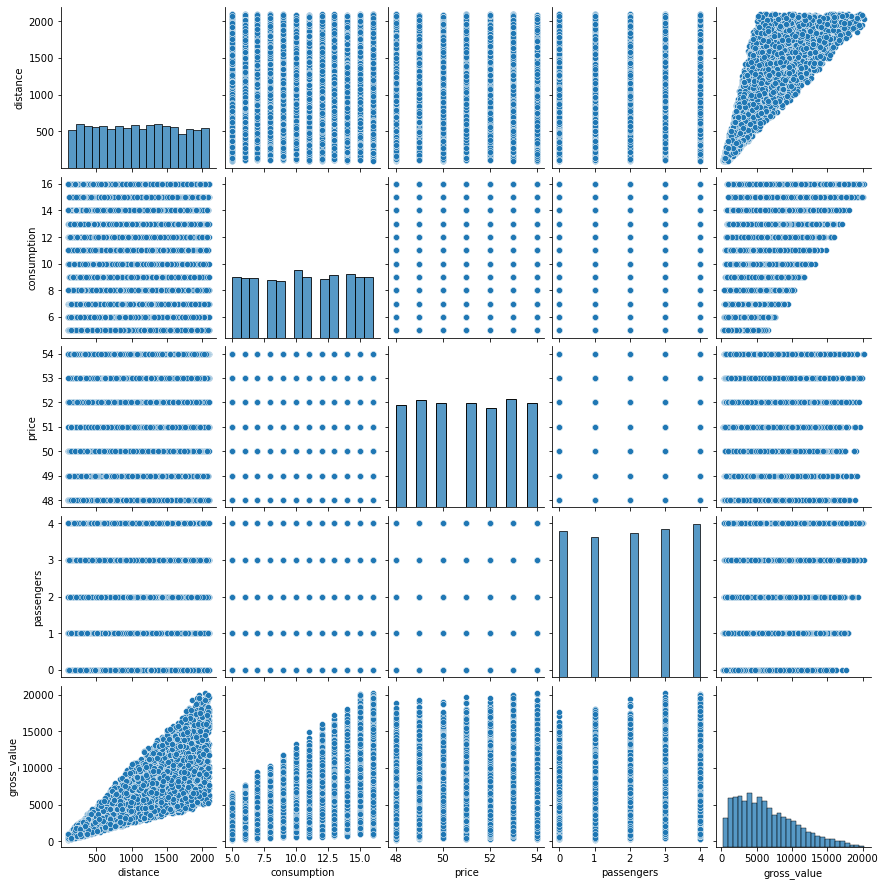

In [5]:
sns.pairplot(data)

1. Сначала обучим модель на полных данных.

In [6]:
X = data[['distance', 'consumption', 'price', 'passengers']]
y = data['gross_value']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['distance', 'consumption', 'price', 'passengers']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [  5.94147001 611.32644963 121.1923466  294.59091667]
Bias: -13245.072686297295
Error: 861.5671020527087


In [7]:
# Получили следующую формулу линейной регрессии (округлим веса до сотых):
# gross_value = 5.94*distance + 611.33*consumption + 121.19*price + 294.59*passengers - 13245.07

# Средняя абсолютная ошибка MAE составила 861.57

2. Попробуем выбросить из модели один из ключевых столбцов - 'distance' и посмотрим, что получится.

In [8]:
X_new = data[['consumption', 'price', 'passengers']]
y_new = data['gross_value']
reg_new = LinearRegression().fit(X_new, y_new)
print('Weights: {}'.format(reg_new.coef_))
print('Bias: {}'.format(reg_new.intercept_))

pred_values_new = reg_new.predict(data[['consumption', 'price', 'passengers']])
print('Error: {}'.format(mean_absolute_error(pred_values_new, y_new)))

Weights: [605.82189968 140.32216357 357.42726894]
Bias: -7820.75872312426
Error: 2939.4448200546058


In [9]:
# Получили следующую формулу линейной регрессии (округлим веса до сотых):
# gross_value = 605.82*consumption + 140.32*price + 357.43*passengers - 7820.76

# Средняя абсолютная ошибка MAE увеличилась в 3.5 раза (по сравнению с моделью на полных данных) и составила 2939.44

# Следовательно, не стоит убирать из модели такие важные параметры, как 'distance'.

3. Теперь попробуем выбросить из модели "неважный" параметр (количество пассажиров),
т.к. мы можем предполагать, что это не ухудшит качество модели (или ухудшит незначительно) 
по причине небольшого влияния введенного поправочного коэфф-та на общую стоимость поездки.

In [10]:
X_new2 = data[['distance', 'consumption', 'price']]
y_new2 = data['gross_value']
reg_new2 = LinearRegression().fit(X_new2, y_new2)
print('Weights: {}'.format(reg_new2.coef_))
print('Bias: {}'.format(reg_new2.intercept_))

pred_values_new2 = reg_new2.predict(data[['distance', 'consumption', 'price']])
print('Error: {}'.format(mean_absolute_error(pred_values_new2, y_new2)))

Weights: [  5.9607611  611.39552627 122.13767934]
Bias: -12716.532033418218
Error: 953.2747144476034


In [11]:
# Мы видим, что MAE снизилась по сравнению с вариантом 2 (с 2939.44 до 953.27), 
# но всё равно выше, чем MAE в варианте №1 (на полных данных MAE=861.57).

# Следовательно, исключение из рассмотрения параметров усложнило задачу построения адекватной модели, 
# но есть более "дорогостоящие" признаки (например, 'distance') и есть менее значительные (например, 'passengers')

4. Попробуем теперь ухудшить качество входящих данных - введём выбросы и пропуски данных в датасет и посмотрим, что получится.

In [12]:
# сделаем копию датасета
data_damaged = data.copy()

# Добавим по 10 выбросов в каждый параметр
for i in range(10):
    data_damaged.loc[np.random.randint(0, 5000), 'distance'] = 10000

for i in range(10):
    data_damaged.loc[np.random.randint(0, 5000), 'consumption'] = 50

for i in range(10):
    data_damaged.loc[np.random.randint(0, 5000), 'price'] = 100

for i in range(10):
    data_damaged.loc[np.random.randint(0, 5000), 'passengers'] = 10

# Введем 500 пропусков данных, произвольно разбросанных по всем колонкам датасета
for i in range(500):
    data_damaged.loc[np.random.randint(0, 5000), np.random.choice(data_damaged.columns)] = np.nan

In [13]:
data_damaged.describe()

,distance,consumption,price,passengers,gross_value
count,4902.000000,4888.000000,4906.000000,4902.000000,4909.000000
mean,1106.770502,10.621113,51.088871,2.043656,6461.614262
std,699.657549,3.879247,2.896208,1.468062,4201.908333
min,100.000000,5.000000,48.000000,0.000000,252.000000
25%,596.250000,8.000000,49.000000,1.000000,3087.740000
50%,1089.500000,11.000000,51.000000,2.000000,5699.430000
75%,1570.000000,14.000000,53.000000,3.000000,9127.870000
max,10000.000000,50.000000,100.000000,10.000000,20219.760000


In [14]:
data_damaged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   distance     4902 non-null   float64
 1   consumption  4888 non-null   float64
 2   price        4906 non-null   float64
 3   passengers   4902 non-null   float64
 4   gross_value  4909 non-null   float64
dtypes: float64(5)
memory usage: 195.4 KB


In [15]:
# Перед обучением модели удалим пропуски и посмотрим, насколько уменьшится датасет.
data_damaged.dropna(inplace=True)
data_damaged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4527 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   distance     4527 non-null   float64
 1   consumption  4527 non-null   float64
 2   price        4527 non-null   float64
 3   passengers   4527 non-null   float64
 4   gross_value  4527 non-null   float64
dtypes: float64(5)
memory usage: 212.2 KB


In [16]:
# Датасет уменьшился на (1 - 4527/5000) = 9,5% строк.
# Это много. Тем не менее, посмотрим, как это повлияет на построение модели (не забудем также про влияние выбросов).

In [17]:
X = data_damaged[['distance', 'consumption', 'price', 'passengers']]
y = data_damaged['gross_value']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data_damaged[['distance', 'consumption', 'price', 'passengers']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [  3.95820294 490.97501804  67.48189669 295.10790808]
Bias: -7196.0266006444945
Error: 1311.10428145776


In [18]:
# Получили следующую формулу линейной регрессии (округлим веса до сотых):
# gross_value = 3.96*distance + 490.98*consumption + 67.48*price + 295.11*passengers - 7196.03

# Средняя абсолютная ошибка MAE составила 1311.10.
# Это существенно больше, чем исходная MAE в варианте №1 (на "хороших" и полных данных MAE=861.57)

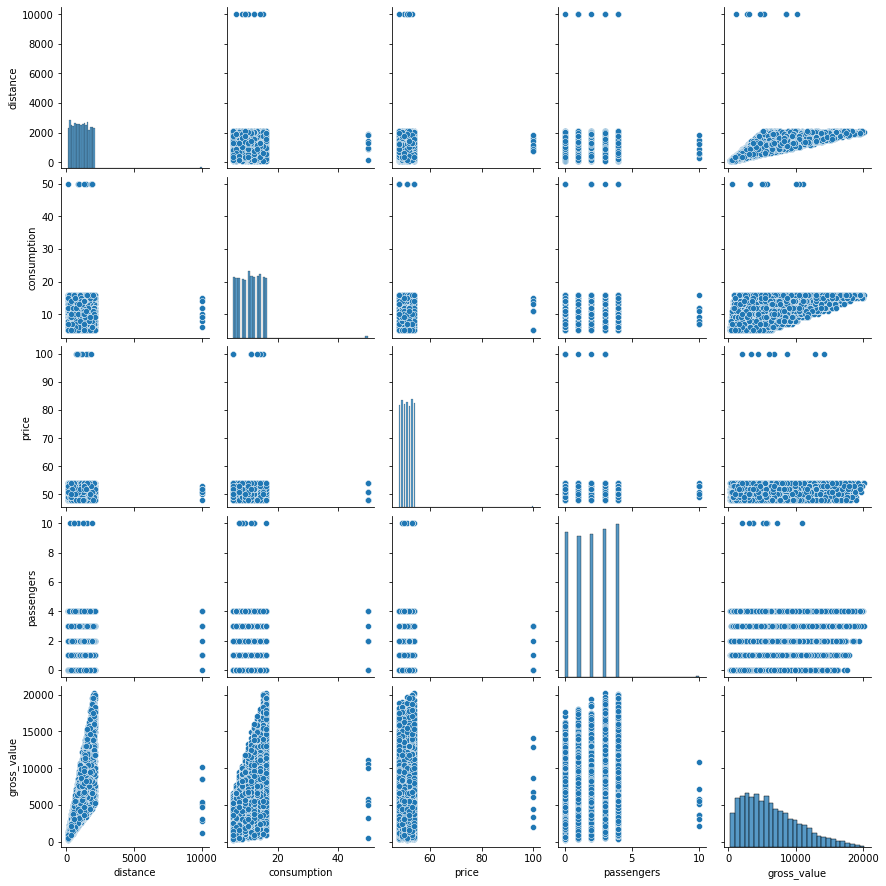

In [19]:
sns.pairplot(data_damaged)
# видим на графиках внедренные в модель выбросы

5. Удалим теперь выбросы из "поврежденного" датасета и рассчитаем параметры модели.

In [20]:
# удалим те же значения выбросов, которые мы внедряли в модель
data_damaged = data_damaged.drop(data_damaged[data_damaged['distance'] == 10000].index)
data_damaged = data_damaged.drop(data_damaged[data_damaged['consumption'] == 50].index)
data_damaged = data_damaged.drop(data_damaged[data_damaged['price'] == 100].index)
data_damaged = data_damaged.drop(data_damaged[data_damaged['passengers'] == 10].index)
data_damaged.describe()

,distance,consumption,price,passengers,gross_value
count,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000
mean,1088.549076,10.537503,51.010461,2.031827,6446.461373
std,572.899253,3.439625,1.999249,1.425069,4198.162218
min,100.000000,5.000000,48.000000,0.000000,300.900000
25%,596.000000,8.000000,49.000000,1.000000,3087.740000
50%,1087.000000,11.000000,51.000000,2.000000,5674.440000
75%,1571.000000,14.000000,53.000000,3.000000,9056.320000
max,2099.000000,16.000000,54.000000,4.000000,20219.760000


In [21]:
X = data_damaged[['distance', 'consumption', 'price', 'passengers']]
y = data_damaged['gross_value']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data_damaged[['distance', 'consumption', 'price', 'passengers']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [  5.93996803 612.02066492 121.89252146 296.6919036 ]
Bias: -13289.275180617602
Error: 858.7702868214514


In [22]:
# Получили следующую формулу линейной регрессии (округлим веса до сотых):
# gross_value = 5.94*distance + 612.02*consumption + 121.89*price + 296.69*passengers - 13289.27
# Средняя абсолютная ошибка MAE составила 858.77

# В первоначальном датасете (вариант №1) параметры модели выглядели следующим образом:
# gross_value = 5.94*distance + 611.33*consumption + 121.19*price + 294.59*passengers - 13245.07
# Средняя абсолютная ошибка MAE составила 861.57

# Можно сделать вывод, что в данном случае удаление части данных (порядка 10%) 
# не ухудшило, а даже позволило незначительно улучшить качество предсказаний модели. 
# Это, конечно же, не является "системным" выводом, просто совпадение (расхождения в пределах погрешности).